In [1]:
"""
Author: Zaw
Learning Curve using RF
"""
import numpy as np
import pandas as pd
import math
import time
import os
import seaborn
import warnings
warnings.simplefilter(action='ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
import pickle
start = time.time()

In [2]:
# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))
    #return (col - np.mean(col))/np.std(col)

# Import descriptor file
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+"/p_chem/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)


## LC informations
# Import LC informations
path = os.getcwd()
data_path = path+"/data/df_2000.csv"
col_list=['LogP','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)

In [3]:
# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))
    #return (col - np.mean(col))/np.std(col)

# Import descriptor file
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+"/p_chem/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)


## LC informations
# Import LC informations
path = os.getcwd()
data_path = path+"/data/df_2000.csv"
col_list=['LogP','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)

In [4]:
des_with_lc = pd.concat([des_df,lc_df],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]
data = des_with_lc.drop(['LogP'],axis=1)

# Remove features with low Variance(threshold<=0.05)
data_var = data.var()
del_feat = list(data_var[data_var <= 0.05].index)
data.drop(columns=del_feat, inplace=True)

# Remove features with correlation(threshold > 0.95)
corr_matrix = data.corr().abs()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
data = data.drop(to_drop,axis=1)

# Scale the features
cols = list(data)
data[cols] = data[cols].apply(scale,axis=0)
data = pd.concat([data,des_with_lc['LogP']],axis=1)

train , rest = train_test_split(data,train_size = 0.8,shuffle=True,random_state = 1)
validate , test = train_test_split(rest, train_size = 0.5, shuffle=True,random_state = 1)

# training set
data_tra_x = train.drop(['LogP'],axis=1)
data_tra_y = train['LogP']

# validation set
data_val_x = validate.drop(['LogP'],axis=1)
data_val_y = validate['LogP']

# test set
data_tes_x = test.drop(['LogP'],axis=1)
data_tes_y = test['LogP']

# The dataset without lc informations
#load the model without lc
path = os.getcwd()
dirname = os.path.dirname(path)
file_path = dirname+"/p_chem/hyperparameters/rf_lc.pkl"
best_parameters_with_lc = pickle.load(open(file_path,'rb'))

n_estimators_list = [10, 50, 100, 200, 300, 400,500]
max_depth_list = range(3, 12)
min_samples_leaf_list = [1, 3, 5, 10, 20, 50]
max_features_list = ['sqrt', 'log2', 0.7, 0.8, 0.9]
min_samples_split_list = [2, 5, 10]


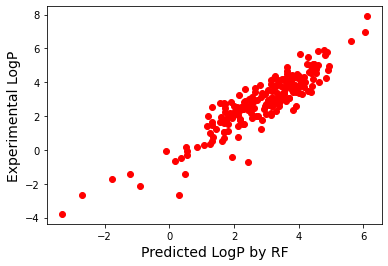

In [5]:
best_model = RandomForestRegressor(n_estimators=n_estimators_list[best_parameters_with_lc['n_estimators']],
                                    max_depth=max_depth_list[best_parameters_with_lc['max_depth']],
                                    min_samples_leaf=min_samples_leaf_list[best_parameters_with_lc['min_samples_leaf']],
                                    min_samples_split = min_samples_split_list[best_parameters_with_lc['min_samples_split']],
                                    max_features=max_features_list[best_parameters_with_lc['max_features']],
                                    min_impurity_decrease=best_parameters_with_lc['min_impurity_decrease'],
                                    n_jobs=-1, random_state=1, verbose=0)
best_model.fit(data_tra_x,data_tra_y)
tes_pred = best_model.predict(data_tes_x)

plt.scatter(tes_pred,data_tes_y,c='r',alpha=1)
plt.xlabel('Predicted LogP by RF',fontsize = 14)
plt.ylabel('Experimental LogP',fontsize = 14)
plt.savefig(dirname+"/p_chem/results/rf_vs.png", format='png', dpi=600)# plt.savefig("svm.png", format='png', dpi=600)
plt.show()

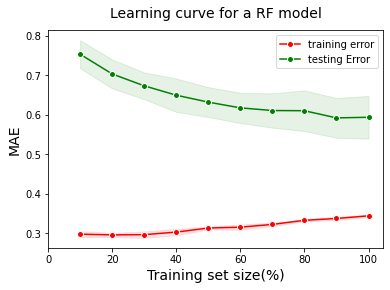

In [6]:
X = data.drop(['LogP'],axis=1)
y = data['LogP']

train_sizes=np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, validation_scores = learning_curve(estimator = RandomForestRegressor(n_estimators=n_estimators_list[best_parameters_with_lc['n_estimators']],
                                    max_depth=max_depth_list[best_parameters_with_lc['max_depth']],
                                    min_samples_leaf=min_samples_leaf_list[best_parameters_with_lc['min_samples_leaf']],
                                    min_samples_split = min_samples_split_list[best_parameters_with_lc['min_samples_split']],
                                    max_features=max_features_list[best_parameters_with_lc['max_features']],
                                    min_impurity_decrease=best_parameters_with_lc['min_impurity_decrease'],
                                    n_jobs=-1, random_state=1, verbose=0),X = X,y = y, train_sizes = train_sizes,
                                    cv = 5,scoring = 'neg_mean_absolute_error')
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

validation_scores_mean = -validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis=1)


fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean,"o-",markeredgecolor='white', label = 'training error',color='r')
ax.fill_between(train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
ax.plot(train_sizes, validation_scores_mean, "o-",markeredgecolor='w', label = 'testing Error',color='g')
ax.fill_between(train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.1,
        color="g",
    )
ax.set_xticks([0,331,662,993,1324,1656])
ax.set_xticklabels([0,20,40,60,80,100,])
ax.set_ylabel('MAE', fontsize = 14)
ax.set_xlabel('Training set size(%)', fontsize = 14)
ax.set_title('Learning curve for a RF model', fontsize = 14, y = 1.03)
ax.legend()
plt.savefig(dirname+"/p_chem/results/rf_lc.png", format='png', dpi=600)
plt.show()